# Spooky Author Identification: GloVe Models

## Implementation

### Import packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from packages import *

Using TensorFlow backend.


In [3]:
INPUT_DIR = '../input/'
TRAIN_FILE_PATH = f'{INPUT_DIR}train.csv'
TEST_FILE_PATH = f'{INPUT_DIR}test.csv'
SAMPLE_SUBMISSION_FILE_PATH = f'{INPUT_DIR}sample_submission.csv'

SUBMISSIONS_DIR = '../submissions/'

EMBEDDINGS_DIR = f'{INPUT_DIR}embeddings/'
GLOVE_EMBEDDINGS_FILE_PATH = f'{EMBEDDINGS_DIR}glove.6B.300d.txt' # Try `glove.840B.300d.txt`

OUTPUT_DIR = '../output/'
OUTPUT_MODELS_DIR = f'{OUTPUT_DIR}glove_cnn_models/'
OUTPUT_LOGS_DIR = f'{OUTPUT_DIR}glove_cnn_logs/'

EMBEDDING_DIM = 300
MAX_FEATURES = 12000 # The top most common words
MAX_SEQUENCE_LENGTH = 900 # Since max number of words in a sentence is 861; try 34 as well

### Load data

In [4]:
train, test, submission = load_data(TRAIN_FILE_PATH, 
                                    TEST_FILE_PATH, 
                                    SAMPLE_SUBMISSION_FILE_PATH)

### Preprocess text

In [5]:
# Todo: Decide whether or not to perform custom text preprocessing beforehand
# X_train_sequences = list(train['text'].apply(lambda x: process_text(x)).values)
# X_test_sequences = list(test['text'].apply(lambda x: process_text(x)).values)
X_train_sequences = list(train['text'].values)
X_test_sequences = list(test['text'].values)

# Tokenize and pad the sentences
X_train_tokenized, X_test_tokenized, word_index = compute_word_index(X_train_sequences,
                                                                     X_test_sequences,
                                                                     MAX_FEATURES,
                                                                     MAX_SEQUENCE_LENGTH)

Found 25943 unique tokens.


### Prepare the embedding layer
These results will later be used during stratified k-fold to construct the embedding layer.

In [6]:
embeddings_index = load_glove_embeddings(GLOVE_EMBEDDINGS_FILE_PATH)

400000it [00:41, 9577.50it/s] 

Found 400000 word vectors.


In [7]:
embedding_matrix, vocab_size = construct_embedding_matrix(word_index, 
                                                          embeddings_index, 
                                                          EMBEDDING_DIM)

### Train the model
Each model will be evaluated based on the logloss metric using either 5-fold or 10-fold cross validation; the lower the logloss, the better the model.

In [8]:
# Fix a random seed for reproducibility
seed = 42
np.random.seed(seed)

In [9]:
# The target classes need to be converted to integers so that
# EAP --> 0
# HPL --> 1
# MWS --> 2
y_train_integers = integer_encode_classes(train['author'].values)

Original class labels: ['EAP' 'HPL' 'MWS']


In [10]:
# The target classes need to be one-hot encoded so that
# EAP --> 0 --> [1, 0, 0]
# HPL --> 1 --> [0, 1, 0]
# MWS --> 2 --> [0, 0, 1]
y_train_encoded = one_hot_encode_classes(y_train_integers)

In [11]:
from models import build_embedding_layer, build_model_callbacks, build_cnn_model

In [12]:
n_splits = 2
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
monitored_metric = 'val_loss'
other_metrics = ['val_acc', 'loss', 'acc']
all_metrics = ['val_loss', 'val_acc', 'loss', 'acc']
all_scores = {
    'val_loss': [],
    'val_acc': [],
    'loss': [],
    'acc': [],
}
best_scores_per_fold = {
    'val_loss': [],
    'val_acc': [],
    'loss': [],
    'acc': [],
}
# The epoch indices in which the best validation loss is recorded
# Note: To retrieve the number of epochs, add 1 to each epoch index
best_score_num_epochs = []

folds = kfold.split(X_train_tokenized, y_train_integers)
for fold, (train_indices, valid_indices) in enumerate(folds):
    # Print the current fold
    nth_fold = fold + 1
    print(f'----- Fold {nth_fold} of {n_splits} -----')
    
    # Prepare the splits of data
    X_train, y_train = X_train_tokenized[train_indices], y_train_encoded[train_indices]
    X_valid, y_valid = X_train_tokenized[valid_indices], y_train_encoded[valid_indices]
    
    # Build the embedding layer
    embedding_layer = build_embedding_layer(embedding_matrix, 
                                            vocab_size, 
                                            EMBEDDING_DIM, 
                                            MAX_SEQUENCE_LENGTH)
    # Construct model callbacks and save the best models with
    # - Format: `fold_{nth_fold}.model.epoch_{epoch_number}.cv_{metric_score}.hdf5`
    # - Example: `fold_01.model.epoch_01.cv_0.8617.hdf5`
    model_file_path = (f'{OUTPUT_MODELS_DIR}fold_{nth_fold:02d}.'
                      'model.epoch_{epoch:02d}.'
                      'cv_{' + monitored_metric + ':.4f}.hdf5')
    logger_file_path = f'{OUTPUT_LOGS_DIR}fold_{nth_fold:02d}.csv'
    model_callbacks = build_model_callbacks(monitored_metric,
                                            'min',
                                            model_file_path,
                                            logger_file_path)
    # Build the model
    model = build_cnn_model(embedding_layer, MAX_SEQUENCE_LENGTH)
    # Train the model
    history = model.fit(X_train,
                        y_train,
                        batch_size=64, # 32, 64, 128, 256, 512
                        epochs=4, # 100
                        verbose=1,
                        callbacks=model_callbacks,
                        validation_data=[X_valid, y_valid],
                        shuffle=True)
    
    # Save the scores for later evaluation
    monitored_metric_fold_scores = history.history[monitored_metric]
    all_scores[monitored_metric].append(monitored_metric_fold_scores)
    # Save only the best validation loss
    epoch_index = np.argmin(monitored_metric_fold_scores)
    best_score_num_epochs.append(epoch_index + 1)
    best_monitored_metric_score = monitored_metric_fold_scores[epoch_index]
    best_scores_per_fold[monitored_metric].append(best_monitored_metric_score)
    
    for metric in other_metrics:
        other_metric_fold_scores = history.history[metric]
        all_scores[metric].append(other_metric_fold_scores)
        # Save only the corresponding current metric score for the
        # best validation loss epoch
        same_epoch_score = other_metric_fold_scores[epoch_index]
        best_scores_per_fold[metric].append(same_epoch_score)

----- Fold 1 of 2 -----
Train on 9789 samples, validate on 9790 samples
Epoch 1/4
9789/9789 [==============================] - 19s 2ms/step - loss: 0.9283 - acc: 0.5632 - val_loss: 0.8618 - val_acc: 0.6138

Epoch 00001: val_loss improved from inf to 0.86181, saving model to ../output/glove_cnn_models/fold_01.model.epoch_01.cv_0.8618.hdf5
Epoch 2/4
9789/9789 [==============================] - 19s 2ms/step - loss: 0.6370 - acc: 0.7423 - val_loss: 0.8490 - val_acc: 0.6272

Epoch 00002: val_loss improved from 0.86181 to 0.84897, saving model to ../output/glove_cnn_models/fold_01.model.epoch_02.cv_0.8490.hdf5
Epoch 3/4
9789/9789 [==============================] - 18s 2ms/step - loss: 0.5370 - acc: 0.7923 - val_loss: 0.8746 - val_acc: 0.6227

Epoch 00003: val_loss did not improve from 0.84897
Epoch 4/4
9789/9789 [==============================] - 18s 2ms/step - loss: 0.4714 - acc: 0.8288 - val_loss: 0.8884 - val_acc: 0.6229

Epoch 00004: val_loss did not improve from 0.84897
----- Fold 2 of 

### Evaluate the results

In [13]:
# Note: There might be a different number of epochs per fold
""" Example:
{
    'val_loss': [[0.8656108248708684, 0.8480148858142459], # Fold 1, scores per epoch
    [0.8535823000075321, 0.8520218395263746]], # Fold 2, scores per epoch

    'val_acc': [[0.6107252297776469, 0.6267620020916075],
    [0.6173255694620041, 0.6308100929066869]],

    'loss': [[0.9227827079133659, 0.6396668943775261],
    [0.9183809885209135, 0.636743621745806]],

    'acc': [[0.5735008681389172, 0.7408315457037562],
    [0.5728294178462978, 0.7402451480737867]]
}
"""
all_scores

{'val_loss': [[0.8618074781317511,
   0.848965035225203,
   0.8746146403245468,
   0.8884351090464334],
  [0.8626325531845647,
   0.8677389611139862,
   0.877062169325974,
   0.8948158339078488]],
 'val_acc': [[0.6137895810713685,
   0.6271705821902321,
   0.6226762002529966,
   0.6228804901622776],
  [0.6221268770582452,
   0.6253958525605533,
   0.6248850751634345,
   0.6271324957314593]],
 'loss': [[0.9282512115511542,
   0.6370386484512234,
   0.53703883852909,
   0.4714091399227687],
  [0.9255146868017039,
   0.6416148972827884,
   0.5418411176343495,
   0.472515570447686]],
 'acc': [[0.5631831646062999,
   0.7422617221770023,
   0.7923179078314007,
   0.8287874144143402],
  [0.5677221656210941,
   0.74147088862537,
   0.7918283963714849,
   0.8273748721725729]]}

In [14]:
best_scores_per_fold

{'val_loss': [0.848965035225203, 0.8626325531845647],
 'val_acc': [0.6271705821902321, 0.6221268770582452],
 'loss': [0.6370386484512234, 0.9255146868017039],
 'acc': [0.7422617221770023, 0.5677221656210941]}

In [15]:
best_score_num_epochs

[2, 1]

In [16]:
# Calculate the mean and standard deviation across all folds' best scores
print('CV Results Summary:')
for metric in all_metrics:
    mean = np.mean(best_scores_per_fold[metric])
    std = np.std(best_scores_per_fold[metric])
    print('- {} mean and std: {:.4f} (+/- {:.4f})'.format(metric, mean, std))

CV Results Summary:
- val_loss mean and std: 0.8558 (+/- 0.0068)
- val_acc mean and std: 0.6246 (+/- 0.0025)
- loss mean and std: 0.7813 (+/- 0.1442)
- acc mean and std: 0.6550 (+/- 0.0873)


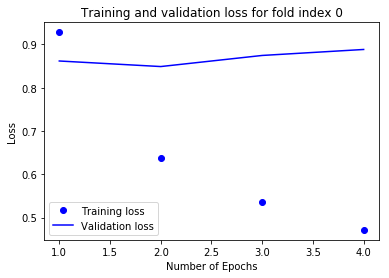

In [17]:
# Pass in a metric (without the `val_` prefix) and a fold index to show
# the training and validation error curves over the number of epochs
display_metric_vs_epochs_plot(all_scores, 'loss', 0)

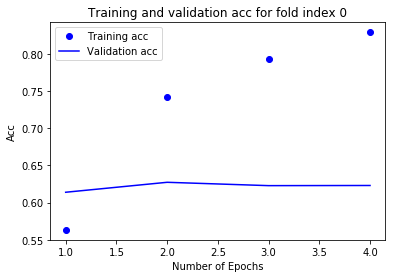

In [18]:
display_metric_vs_epochs_plot(all_scores, 'acc', 0)

### Make predictions on the test data
In order to make predictions on the Kaggle-provided unlabeled test data, we will need to submit our predictions to Kaggle. It would be best to train on the entire training set; this means that, this time, we won't provide a validation set to the Keras model.

How do we know how many epochs to train for? To figure this out, we can use the results from the cross validation phase. Since we have recorded the number of epochs that each fold took to train the model before stopping, we can take the average number of epochs across all folds and use that as the number of epochs to train our final model.

#### Calculate the number of epochs to train for using the entire training dataset

In [19]:
best_score_num_epochs

[2, 1]

In [20]:
# Let's take the average number of epochs across all folds.
final_num_epochs = np.mean(best_score_num_epochs)
# We take the ceiling because it's better to train for a little longer than to underfit.
final_num_epochs = np.ceil(final_num_epochs)
# We need to cast it to an int before feeding it to `model.fit`.
final_num_epochs = int(final_num_epochs)
final_num_epochs

2

#### Train the model

In [21]:
# Build the embedding layer
embedding_layer = build_embedding_layer(embedding_matrix, 
                                        vocab_size, 
                                        EMBEDDING_DIM, 
                                        MAX_SEQUENCE_LENGTH)
# Build the model
model = build_cnn_model(embedding_layer, MAX_SEQUENCE_LENGTH)

In [22]:
# Train the model
history = model.fit(X_train_tokenized,
                    y_train_encoded,
                    batch_size=64,
                    epochs=final_num_epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/2
19579/19579 [==============================] - 26s 1ms/step - loss: 0.8842 - acc: 0.5964
Epoch 2/2
19579/19579 [==============================] - 27s 1ms/step - loss: 0.6554 - acc: 0.7255


#### Make predictions on the test data

In [23]:
predictions = model.predict(X_test_tokenized, batch_size=64, verbose=1)

8392/8392 [==============================] - 5s 619us/step


In [24]:
# Check the final submission values
predictions[0:3]

array([[0.03579558, 0.01009183, 0.9541125 ],
       [0.93095404, 0.06735893, 0.00168709],
       [0.00521636, 0.9862598 , 0.00852381]], dtype=float32)

#### Create a submission CSV

In [25]:
submission[['EAP', 'HPL', 'MWS']] = predictions
submission.to_csv(f'{SUBMISSIONS_DIR}001_submission.csv', index=False)

### Evaluate the average logloss of the Kaggle submission
After submitting to Kaggle, we can calculate the average logloss across the entire test dataset as follows:
```
Given:
    n_test = 8392
    %_private = 0.7
    %_public = 0.3
Average logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
                = (private_logloss * (%_private * n_test)
                  + public_logloss * (%_public * n_test))
                  / n_test
Where n_test = n_private + n_public
```

## Refinement
Run random search to tune certain hyperparameters for each algorithm for at least 60 iterations (but I’ll lower that number if it ends up taking way too long) in order to find the best model.